In [1]:
import sys
import os
sys.path.append('Modules/demCreationComponents/')
sys.path.append('Modules/demAnalysisComponents/')
import baseGrid as bg
import dem as dpy
from matplotlib import pyplot as plt
import numpy as np
from importlib import reload
from scipy.signal import fftconvolve    # Gaussian Filter
from sklearn import cluster             # K-means Clustering

#%matplotlib notebook
%matplotlib inline
%matplotlib widget
## include 'notebook' when using traditional jupyter notebook interface
## include 'widget' when using VSCODE jupyter notebooks for interactive plots
## include inline for viewing figs in VSCODE

print(os.getcwd())
print("test")

/workspaces/rgr/src
test


raster min:  -9999.0
raster max:  2616.242919921875
<class 'dem.demGrid'>


/opt/conda/envs/rgr/lib/python3.8/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


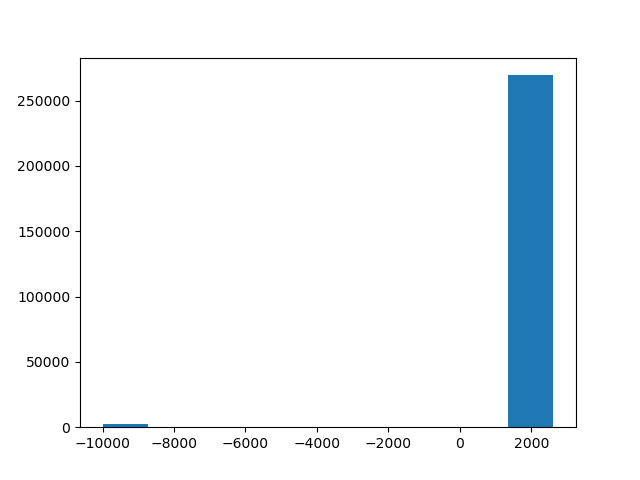

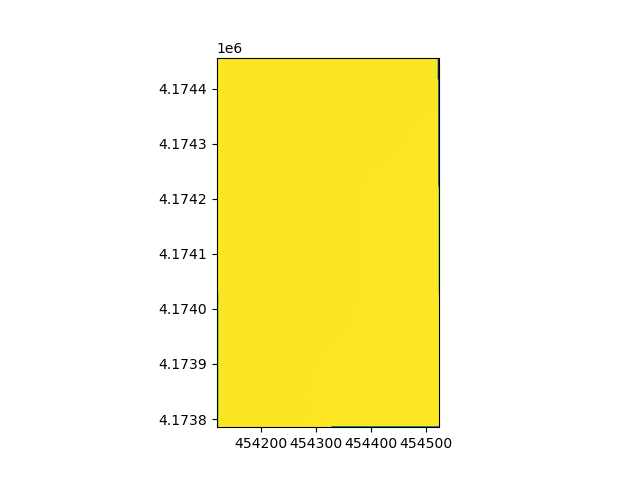

In [2]:
#Define a path to some data to test out functions

testDataPath = os.path.join('Quals_DEMs','demsd2011.tif')
#'RGR_Map_PostField/clDEM_graben','clDEM_graben.tif' 
# OG TEST DATA PATH: 'testData/dem_test1_slv.tif'


#Load the grid in, grids 'require' 
testDEM = dpy.demGrid([],rasterPath = testDataPath)

#print min & max values of raster
print('raster min: ',testDEM.min())
print('raster max: ',testDEM.max())



#Check to make sure it looks right
testDEM.plotHistogram()
testDEM.plotGrid()
print(type(testDEM))

In [3]:
ndv = testDEM.ndv(testDataPath)
print(ndv)

-9999.0


2616.242919921875
2518.35009765625


<Axes: >

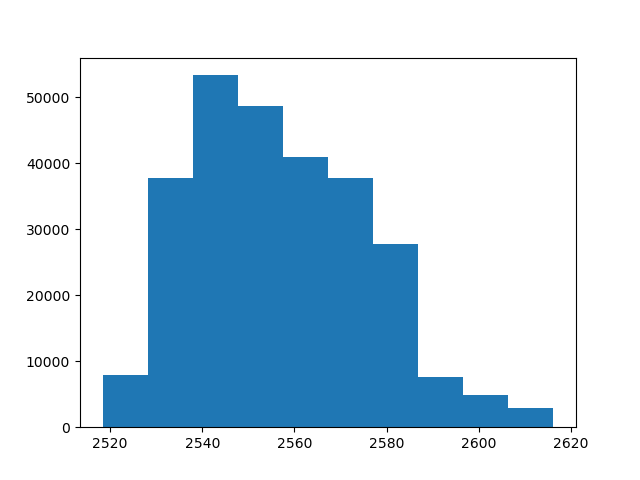

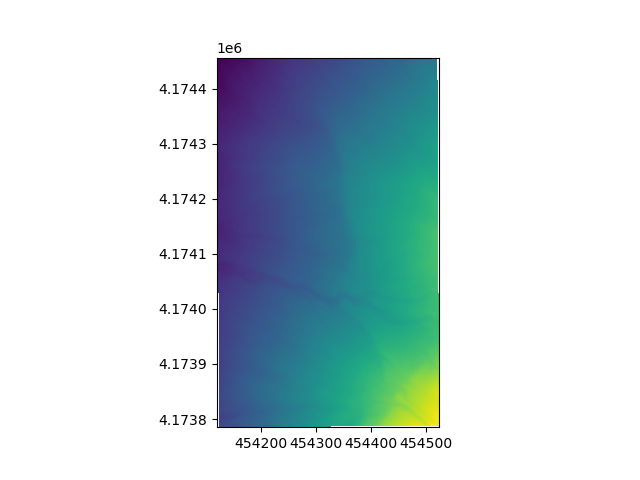

In [4]:
# No data value is causing issues-- remove w/ Masked Grid function
testDEM.getGridExtent()
testDEM_n = testDEM.returnMaskedGrid(testDEM!=ndv)
DEMarr = testDEM.returnMaskedGrid(testDEM!=ndv, returnAsArray=True)
print(testDEM_n.max())
print(testDEM_n.min())
testDEM_n.plotHistogram()
testDEM_n.plotGrid()

In [5]:

#Calculate the magnitude of slope
slopeMag = testDEM.calcFiniteSlopeMagOverWindow(N = 2)

#slopeMag.overwriteSaveFile()
# slopeMag = None #If you are working w/ big datasets, you may need to set things to none to free memory after creating them

#Calculate the laplacian of the surface (e.g., curvature)
L = testDEM.calcFiniteLaplacianOverWindow(N = 2) #N here is related to the size of the centered difference kernel. 1=look at neighbornig cells, 2 = look two cells away
#L.overwriteSaveFile()
# L = None

#Hillshade
#Vary az/el for other shading directions, but you'll need to specify a unique name with .saveGrid to not
#continually overwrite files w/ the default name for a hillshade
hs = testDEM.calcHillshade(azimuth = 315, altitude=45)
# hs.saveGrid(outfilePath = <insert your preferred name>)
#hs.overwriteSaveFile()
# hs = None

<Axes: >

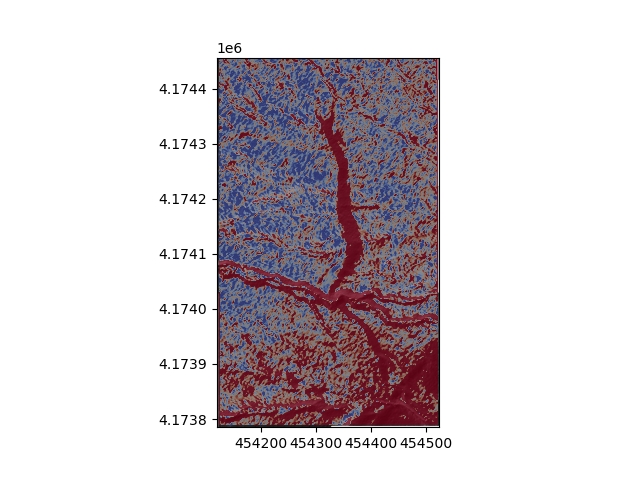

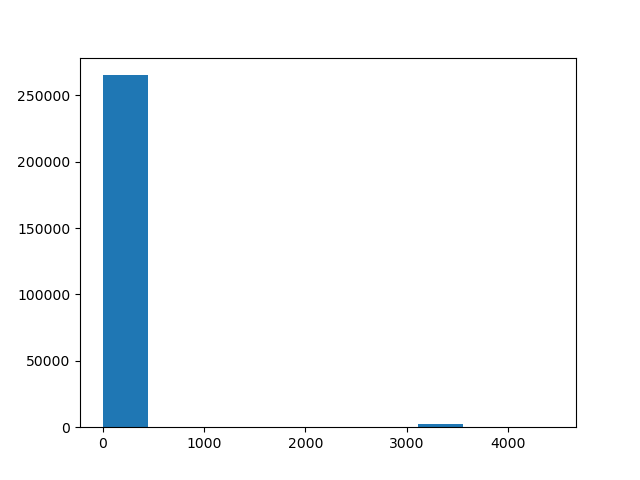

In [6]:
ax = hs.plotGrid(cmap = 'Greys')#,vmin = 0, vmax = 255)
vmin,vmax = slopeMag.percentile([10,75])
slopeMag.plotGrid(axs = ax, cmap = 'coolwarm', alpha = 0.5, vmin = vmin, vmax = vmax)
slopeMag.plotHistogram()


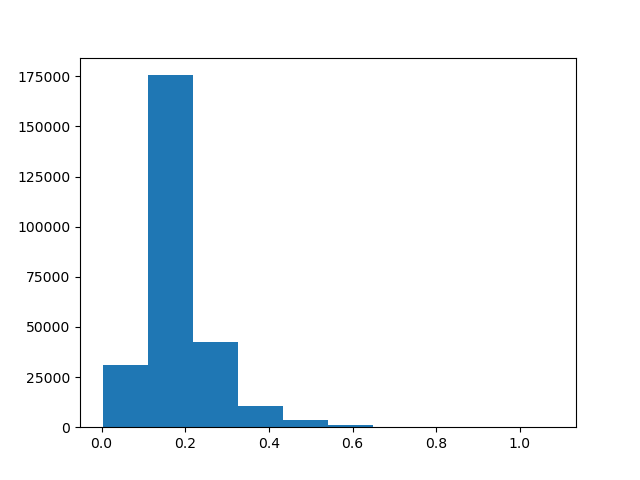

In [7]:
# instead of setting nan to 0, interpolate to equal nearby values
# or crop out rows w/ nan values

slopeMag = slopeMag.returnMaskedGrid(slopeMag<3000)
slopeMag.plotHistogram()

slopeMagArr = slopeMag.returnMaskedGrid(slopeMag<3000, returnAsArray=True)
slopeMagArr[np.isnan(slopeMagArr)] = 0

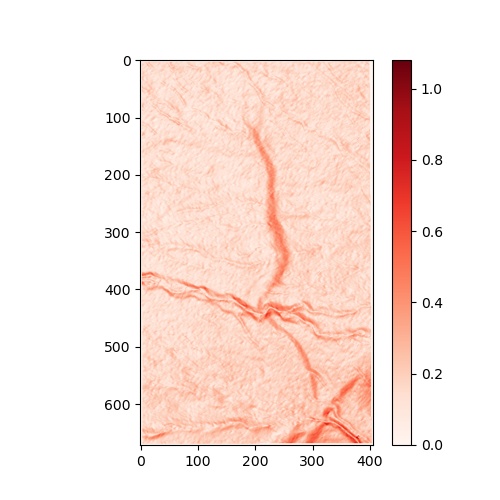

In [8]:
# plot slopeArr
plt.figure(figsize=(5,5))
plt.imshow(slopeMagArr, cmap="Reds")
plt.colorbar()
plt.show()

In [9]:

# flatten data for input into classifier
X = slopeMagArr.reshape((-1,1))
#print (X.shape)
#print(X)

# normalize array for consistent scaling
normalized_values = (X - np.mean(X)) / np.std(X)
print('normalized values', normalized_values)
#run the classifier
k_means = cluster.KMeans(n_clusters=2)

# Fitting the model to testing set
k_means.fit(X.reshape(-1, 1))
#k_means.fit(X)

labels= k_means.labels_

# Separate the values into high and low categories based on the labels and value
if np.mean(X[labels == 1]) > np.mean(X[labels == 0]):
    high_values = X[labels == 1]
    low_values = X[labels == 0]

if np.mean(X[labels == 1]) < np.mean(X[labels == 0]):
    high_values = X[labels == 0]
    low_values = X[labels == 1]

# Print or use the high_values and low_values arrays as needed
print("High Values:", high_values)
print("Low Values:", low_values)

labels = labels.reshape(slopeMagArr.shape)

#print(len(X_cluster))

normalized values [[-2.11797156]
 [-2.11797156]
 [-2.11797156]
 ...
 [-2.11797156]
 [-2.11797156]
 [-2.11797156]]


/opt/conda/envs/rgr/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


High Values: [[0.27671545]
 [0.3299727 ]
 [0.24801964]
 ...
 [0.26571993]
 [0.2782686 ]
 [0.26820202]]
Low Values: [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


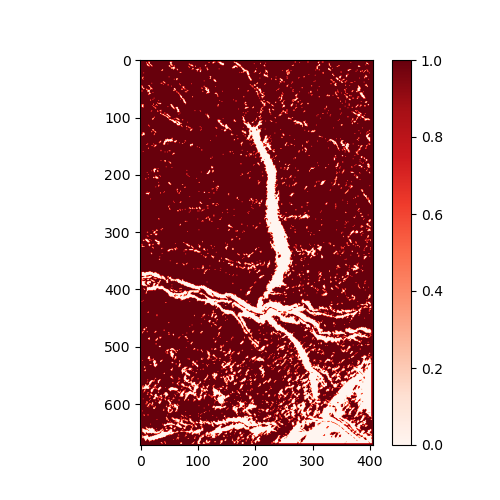

In [10]:
# plot cluster result
plt.figure(figsize=(5,5))
plt.imshow(labels, cmap="Reds")
plt.colorbar()
plt.show()

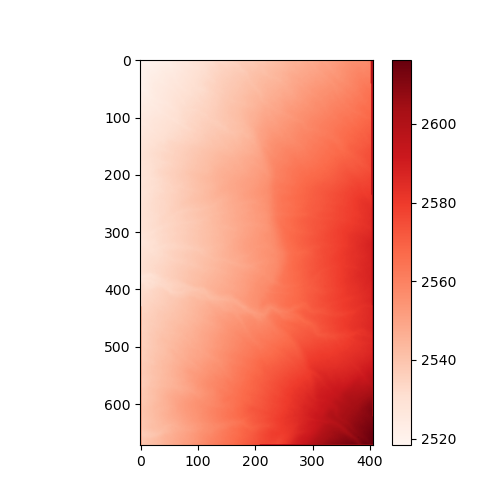

In [11]:
DEMarr[np.isnan(DEMarr)] = 2600
# plot slopeArr
plt.figure(figsize=(5,5))
plt.imshow(DEMarr, cmap="Reds")
plt.colorbar()
plt.show()
